In [34]:
import os
import email
from email import policy
from sklearn.cluster import KMeans
from transformers import BertModel, BertTokenizer
from sklearn.cluster import MiniBatchKMeans
from tqdm import tqdm
import numpy as np
from sklearn.manifold import TSNE


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
def read_email_with_progress(file_path):
    with tqdm(total=1, desc='Reading email') as pbar:
        with open(file_path, 'r', encoding='latin-1') as f:
            email_msg = email.message_from_file(f, policy=policy.default)
            pbar.update(1)
    return email_msg


    
def extract_text_with_progress(email_msg):
    if email_msg.is_multipart():
        parts = [part for part in email_msg.iter_parts() if part.get_content_type() == 'text/plain']
        total_parts = len(parts)
        text = ''
        with tqdm(total=total_parts, desc='Extracting text') as pbar:
            for part in parts:
                text += part.get_payload(decode=True).decode('latin-1')
                pbar.update(1)
        return text
    else:
        return email_msg.get_payload(decode=True).decode('latin-1')
    
    




def encode_text_with_progress(text):
    inputs = tokenizer(text, return_tensors='pt', max_length=512, truncation=True)
    outputs = model(**inputs)
    return tqdm(outputs.last_hidden_state[:,0,:].detach().numpy(), desc='Encoding text')

In [ ]:
# email_msg = read_email('data/archives-EGC/polytech_liste-egc_archives-2006-2010/polytech_liste-egc_2006-03/4')
# print(extract_text(email_msg))

In [ ]:
email_vectors = []
# for root, dirs, files in tqdm(os.walk('data/archives-EGC/polytech_liste-egc_2009-12'), desc='Processing emails'):
# for root, dirs, files in tqdm(os.walk('data/file_list'), desc='Processing emails'):
#     for file in tqdm(files, desc='Processing files'):
#         if file != '.DS_Store':
#             file_path = os.path.join(root, file)
#             email_msg = read_email(file_path)
#             text = extract_text(email_msg)
#             vector = encode_text(text)
#             email_vectors.append(vector)
#             # tqdm.write(f'Processing file: {file_path}')
            
i = 0
files = os.listdir('data/file_list')
print(len(files))
print(files[0])

In [21]:
import concurrent.futures
def read_email(file_path):
    with open(file_path, 'r', encoding='latin-1') as f:
        return email.message_from_file(f, policy=policy.default)
def extract_text(email_msg):
    if email_msg.is_multipart():
        return ''.join(part.get_payload(decode=True).decode('latin-1') for part in email_msg.iter_parts() if part.get_content_type() == 'text/plain')
    else:
        return email_msg.get_payload(decode=True).decode('latin-1')
def encode_text(text):
    inputs = tokenizer(text, return_tensors='pt', max_length=512, truncation=True)
    outputs = model(**inputs)
    return outputs.last_hidden_state[:,0,:].detach().numpy()


100%|██████████| 10820/10820 [1:15:34<00:00,  2.39it/s]


In [ ]:
def process_file(file):
    if file != '.DS_Store':
        file_path = os.path.join('data/file_list/', file)
        email_msg = read_email(file_path)
        text = extract_text(email_msg)
        vector = encode_text(text)
        return vector
    else:
        return None

files = os.listdir('data/file_list')

with concurrent.futures.ThreadPoolExecutor() as executor:
    email_vectors = list(tqdm(executor.map(process_file, files), total=len(files)))

email_vectors = [vector for vector in email_vectors if vector is not None]

### Second for testing

In [52]:
import concurrent.futures

def process_file(file):
    if file != '.DS_Store':
        file_path = os.path.join('data/testing_list', file)
        email_msg = read_email(file_path)
        text = extract_text(email_msg)
        vector = encode_text(text)
        return vector
    else:
        return None

files = os.listdir('data/testing_list')
def process_folder(folder):
    files = os.listdir(folder)
    with concurrent.futures.ThreadPoolExecutor() as executor:
        email_vectors = list(tqdm(executor.map(process_file, files), total=len(files)))
    email_vectors = [vector for vector in email_vectors if vector is not None]
    return email_vectors
    # np.save(f'{folder}.npy', email_vectors)
    

folders = os.listdir('data/testing_list')
# with concurrent.futures.ThreadPoolExecutor() as executor:
#     email_vectors = list(tqdm(executor.map(process_file, files), total=len(files)))

# email_vectors = [vector for vector in email_vectors if vector is not None]
# np.save('email_vectors_test.npy', email_vectors)

In [ ]:
# def process_emails():
#     email_vectors = []
#     files = os.listdir('data/file_list')

#     for file in tqdm(files):
#         if file != '.DS_Store':
#             file_path = os.path.join('data/file_list/', file)
#             email_msg = read_email(file_path)
#             text = extract_text(email_msg)
#             vector = encode_text(text)
#             email_vectors.append(vector)


In [22]:
# np.save('email_vectors.npy', email_vectors)

In [42]:
all_vectors= np.load('email_vectors_test.npy')
reshaped_vectors = np.reshape(all_vectors, (len(all_vectors), -1))

kmeans = KMeans(n_clusters=10, n_init=10, random_state=0)
kmeans.fit(reshaped_vectors)


KMeans(n_clusters=10, n_init=10, random_state=0)

In [43]:
print(kmeans.labels_)

[7 3 4 3 4 3 5 3 0 7 7 0 8 1 7 4 6 1 0 1 3 1 3 3 0 7 7 7 0 2 3 0 7 2 2 7 1
 6 4 5 0 3 7 0 7 0 1 4 4 4 2 1 7 7 7 2 4 7 2 3 8 7 4 7 0 2 3 2 9 0 7 0 4 3
 1 7 7 7 2 7 3 0 1 0 0 6 9 1 0 4 1 7 6 4 1 3 7 6 4 1 0 4 1 7 4 1 3 0 3 2 7
 0 7 4 1 4 4 0 1 7 6 7 2 3 2 7 6 2 7 1 7 1 3 8 7 0 4 3 1 2 6 6 7 0 3 6 4 1
 1 7 3 7 0 7 0 7 4 3 1 6 1 4 0 7 7 0 0 3 8 4 7 7 4 1 0 1 3 0 1 1 0 1 7 1 1
 7 4 1 2 1 6 1 3 1 2 4 7 4 0 7 0 2 0 5 4 2 3 0 3 3 1 2 5 6 6 3 0 7 1 1 6 3
 0 5 9 0 8 0 1 7 2 7 1 4 6 7 7 1 7 5 4 7 3 7 8 4 4 1 3 5 2 7 4 7 3 0 0 1 8
 2 5 3 0 8 2 7 1 7 7 2 7 1 6 3 3 3 7 8 2 6 3 0 7 8 4 0 4 1 1 7 5 0 7 7 7 1
 2 1 4 1 7 3 1 4 3 0 1 3 1 1 4 7 3 6 5 4 7 7 7 9 1 0 3 3 4 7 1 0 4 0 4 5 7
 7 7 7 7 0 9 6 3 1 1 7 1 0 7 0 7 2 7 6 2 9 7 4 4 5 1 0 7 0 2 7 6 9 3 1 0 3
 4 1 1 7 0 6 7 7 3 2 1 4 1 2 5 2 0 7 3 7 7 7 0 1 6 1 2 0 2 1 7 8 0 2 8 7 3
 4 7 2 5 4 0 1 0 1 6 1 7 2 4 0 6 7 5 1 3 3 5 2 8 0 1 7 3 7 4 4 0 0 7 0 7 4
 0 0 2 1 7 8 7 7 4 2 7 4 4 1 7 0 0 6 0 2 7 4 1 0 0 7 7 4 6 6 7 1 3 9 0 1 0
 7 1 6 1 6 7 1 3 1 8 0 1 

100%|██████████| 50/50 [06:56<00:00,  8.32s/it]


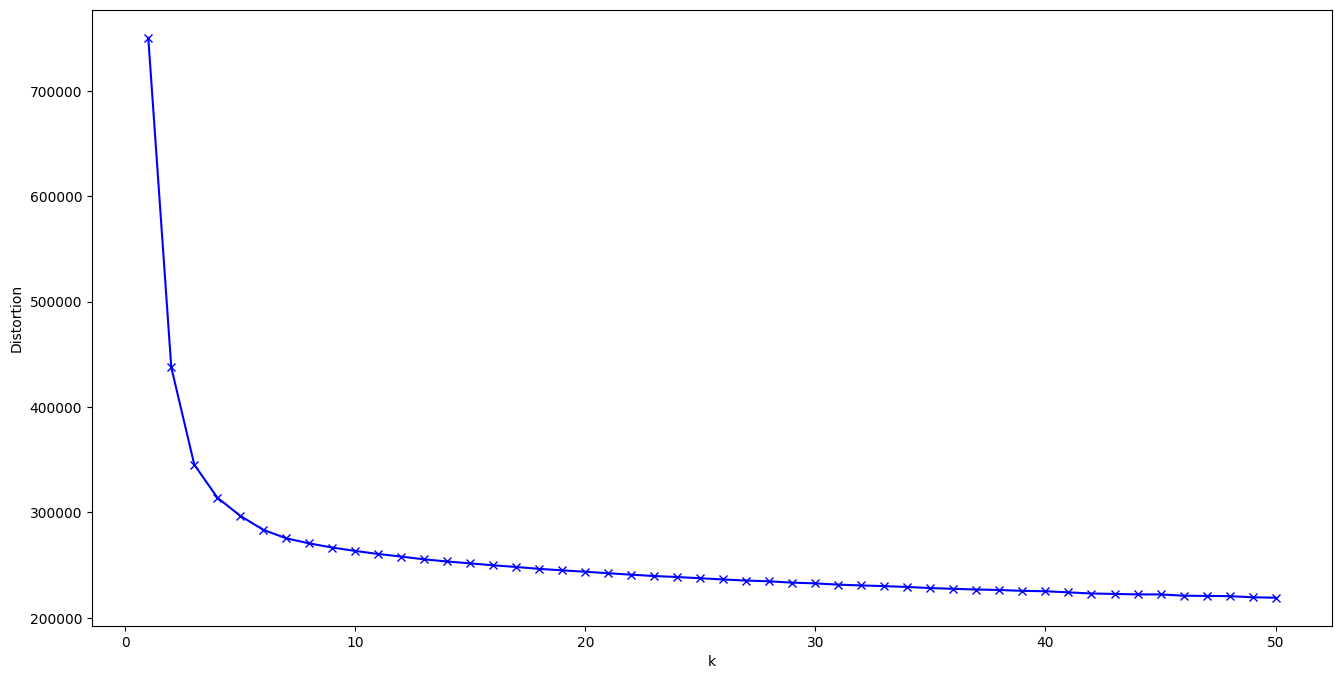

In [32]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

distortions = []
K = range(1,51)
for k in tqdm(K):
    kmeanModel = KMeans(n_clusters=k, n_init=10, random_state=0)
    kmeanModel.fit(reshaped_vectors)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.show()

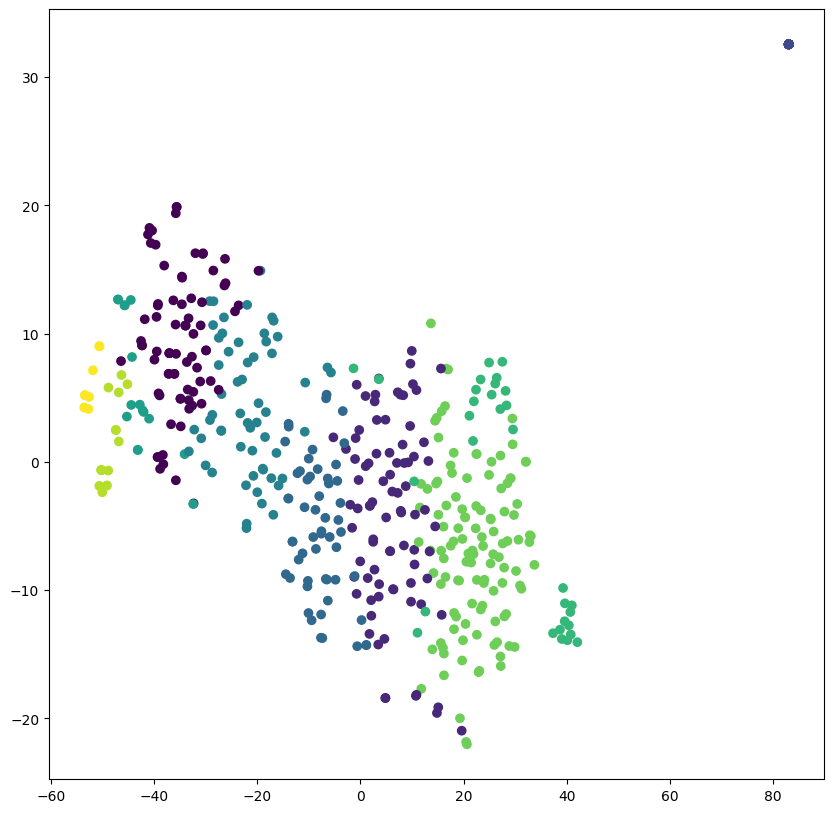

In [59]:
reshaped_vectors = np.reshape(email_vectors, (len(email_vectors), -1))

predictions = kmeans.predict(reshaped_vectors)

tsne = TSNE(n_components=2, random_state=0)
email_vectors_2d = tsne.fit_transform(reshaped_vectors)

plt.figure(figsize=(10, 10))
plt.scatter(email_vectors_2d[:, 0], email_vectors_2d[:, 1], c=predictions)
plt.show()

100%|██████████| 99/99 [00:38<00:00,  2.58it/s]


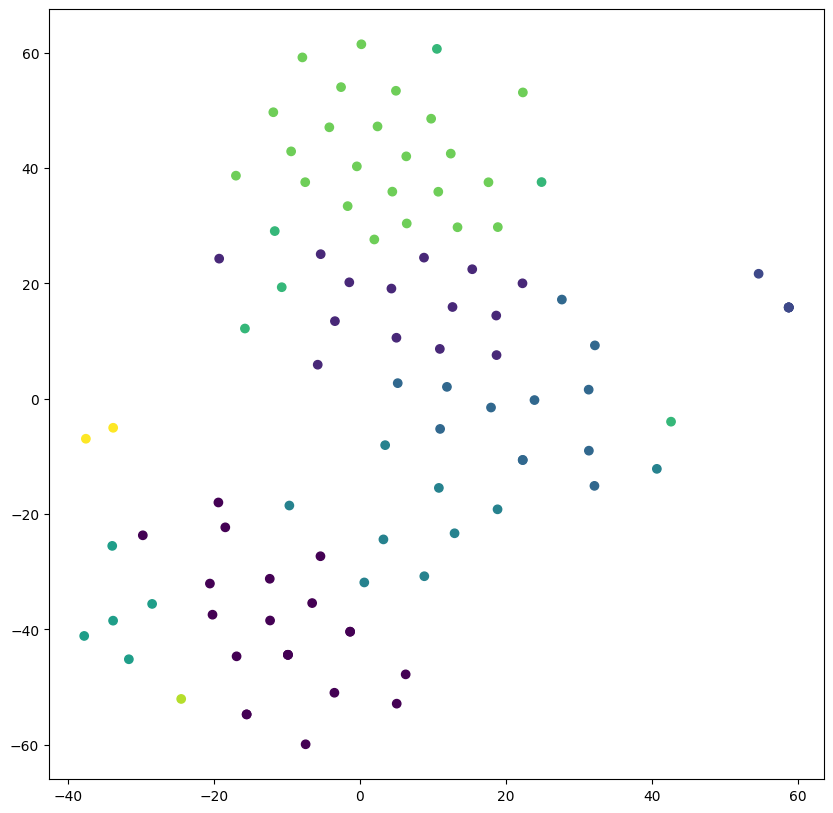

In [57]:
data = []
filenames = []  
data = process_folder('data/testing_list')
reshaped_vectors = np.reshape(data, (len(data), -1))

predictions = kmeans.predict(reshaped_vectors)

tsne = TSNE(n_components=2, random_state=0)
data_2d = tsne.fit_transform(reshaped_vectors)

plt.figure(figsize=(10, 10))
scatter = plt.scatter(data_2d[:, 0], data_2d[:, 1], c=predictions)

for i, filename in enumerate(filenames):
    plt.annotate(filename, (data_2d[i, 0], data_2d[i, 1]))

plt.show()

In [ ]:
# n_batches = 10
# batch_size = len(email_vectors) 
# kmeans = MiniBatchKMeans(n_clusters=10)
# for i in tqdm(range(n_batches)):
#     start = i * batch_size
#     end = (i + 1) * batch_size
#     kmeans.partial_fit(email_vectors[start:end])

# if len(email_vectors) % n_batches != 0:
#     kmeans.partial_fit(email_vectors[n_batches * batch_size:])
